# 1 - Deep Dive into CNN for Keras

Keras (ケーラス)は、GoogleのFrançais Chollet (フランソワ・ショレ)が開発している、ディープラーニングライブラリ。

## 特徴

- 高い抽象度
- バックエンドはTensorFlowもしくはTheano

## インストール

macOSを使っているなら、

```
brew install python3
pip3 install keras
```

## ソースコード

```
git clone https://github.com/fchollet/keras.git
```

グラフ描画のために`matplotlib`を、テンソル計算のために`numpy`をそれぞれインポートします。

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

MNISTデータセットをインポートします。

(60000, 28, 28) uint8 [  0  45 186 253]


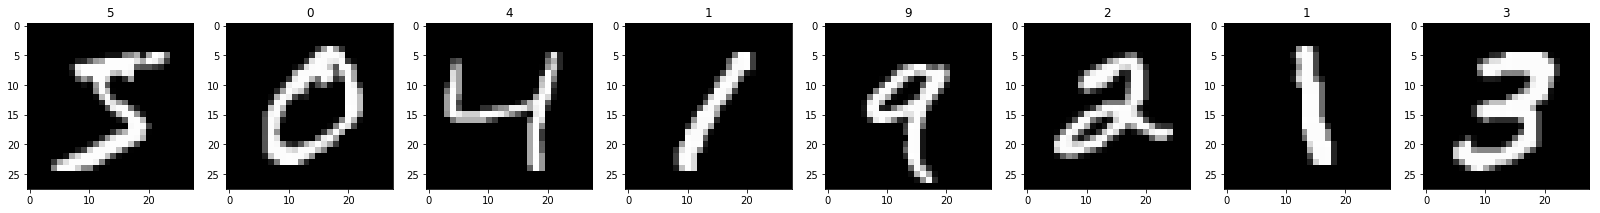

In [18]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_train.dtype, X_train[0][15][13:-11])

figure, axes = plt.subplots(1,8, figsize=(28, 28))
for i, data in enumerate(X_train[:8]):
    axes[i].imshow(data, cmap='gray')
    axes[i].set_title(y_train[i])
figure.subplots_adjust(hspace=0)
plt.show()

## MNIST
Facebook AIのYann LeCun (ヤン・ル・カン)による手書き文字データセット「MNIST」はCNNによる文字識別タスクの試金石になっている。

生データは0 - 255のintが28x28ピクセルある60000サンプル分のテンソル。

データセットを、TensorFlowで扱えるシェイプに変換します。

In [19]:
img_rows, img_cols = 28, 28 # 入力画像の次元数

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
print(X_train.shape, X_train.dtype, X_train[0][15][13:-11])

(60000, 28, 28, 1) uint8 [[  0]
 [ 45]
 [186]
 [253]]


floatに変換します

In [20]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print(X_train.shape, X_train.dtype, X_train[0][15][13:-11].T)

(60000, 28, 28, 1) float32 [[   0.   45.  186.  253.]]


0.0 - 1.0 に正規化します

In [21]:
X_train /= 255
X_test /= 255
print(X_train.shape, X_train.dtype, X_train[0][15][13:-11].T)

(60000, 28, 28, 1) float32 [[ 0.          0.17647059  0.72941178  0.99215686]]


In [22]:
print(X_train.shape[0], '訓練サンプル')
print(X_test.shape[0], 'テストサンプル')

60000 訓練サンプル
10000 テストサンプル


In [23]:
from keras.utils import np_utils

nb_classes = 10 # クラスの数。y_trainで網羅されている以上の数にするとzero-paddingされる
print(y_train[:10]) # 数字がラベルになっている

[5 0 4 1 9 2 1 3 1 4]


クラスの数×サンプル数のOne-hotベクトルに変換する

In [24]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
print(Y_train[:10])

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


# モデルの構築

モデルの構築に必要なレイヤーや活性化関数、定数項を準備します。

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

nb_filters = 32 # 畳み込みフィルターの数
pool_size = (2, 2) # Maxプーリングに於けるプーリングエリアのサイズ
kernel_size = (3, 3) # 畳み込みカーネルのサイズ

input_shape = (img_rows, img_cols, 1)

シーケンシャルモデルを宣言します。これに`add`関数を使ってレイヤーを追加していきます。

In [26]:
model = Sequential()

最初の畳み込み層をします。活性化関数としてReLUを加えます。

In [27]:
model.add(Convolution2D(nb_filters, # 畳み込みフィルターの数
                        kernel_size[0], # 畳み込みカーネルのサイズ
                        kernel_size[1], # 畳み込みカーネルのサイズ
                        border_mode='valid', # 境界モード
                        input_shape=input_shape)) # 入力シェイプ
model.add(Activation('relu'))

Convolution2Dがモデルの最初になる場合は、__input_shape__ が必須になります。

## ドキュメントに載っていない`border_mode`

[StackOverflow](http://datascience.stackexchange.com/questions/11840/border-mode-for-convolutional-layers-in-keras)の議論によると、
> 境界モード (border_mode)が "有効 (valid)"の場合、コンボリューションは入力とフィルタが完全に重なるところでのみ計算されるため、入力よりも小さい出力が得られます。 

> 境界モード (border_mode)が "同じ (same)"の場合、入力と同じサイズの出力が得られます。
つまり、フィルタは "filter size / 2"で入力の範囲外になければなりません。入力の外側の領域は通常0で埋められます。

## Rectified Linear Unit (ReLU)とは？

$f(x) = \max(0, x)$ のことです。

[CS231n](http://cs231n.github.io/neural-networks-1/)から利点・欠点を引用。

> ### 利点
> - Sigmoid / tanh関数と比較して確率的勾配降下の収束を大幅に加速することが分かっています。
> - 高価な操作（指数関数など）を伴うtanh / sigmoidニューロンと比較して、ReLUは活性化マトリックスを単純にゼロで閾値処理することで実装できます。 

> ### 欠点

> - 残念ながら、ReLUユニットは訓練中に壊れやすく、「死ぬ」可能性があります。
例えば、ReLUニューロンを流れる大きな勾配は、ニューロンがデータポイント上で決して活性化しないように重みを更新させる可能性があります。
これが起こると、ユニットを流れる勾配はその時点から永遠にゼロになります。

さらに畳み込み層 + ReLUを追加します。

In [28]:
model.add(Convolution2D(
    nb_filters,
    kernel_size[0],
    kernel_size[1]))
model.add(Activation('relu'))

マックスプーリング層を追加します。

In [29]:
model.add(MaxPooling2D(pool_size=pool_size))

## マックスプーリング層とは
プーリング層は、任意のシェイプ内での代表値を求めて圧縮する層です。
その中でも__マックスプーリング__は、シェイプ内の最大値を代表値とするレイヤーです。

他にも__平均プーリング__があり、それは平均値を代表値とします。

次に、ドロップアウト層をドロップ率0.25として追加します。

In [30]:
model.add(Dropout(0.25))

## ドロップアウト層とは

Kerasドキュメントから引用

> ドロップアウトは、訓練時のそれぞれの更新において入力ユニットのpをランダムに0にセットすることであり、それは過学習を防ぐのを助ける。

続いて、入力を平坦化します。バッチサイズに影響されません。
例えば、`(12, 12, 32)`のシェイプは`(4608)`になります。

In [31]:
model.add(Flatten())

128次元の全結合レイヤー (fully-connected layer) + ReLUを追加します。

In [32]:
model.add(Dense(128))
model.add(Activation('relu'))

## 全結合層とは

単純に$z = Wx + b$の線形結合を行うレイヤーです。

ドロップアウト層

In [33]:
model.add(Dropout(0.5))

予測したいクラスと同じ数の全結合レイヤー

In [34]:
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

## ソフトマックスとは？

シグモイド関数の多変量版。
出力の各成分は0から1の間をとり、全成分の和が1.0になる。
もっとも大きい$x_i$が強調される性質。

もっとも大きい$x_i$が1に、それ以外は0になるマックス関数をソフトにしたバージョンと考える。

$$\frac{\exp(a_i)}{\sum_j^n \exp(a_j)},\;i=1,\ldots,n$$


仕上げにモデルの可視化をしてみます。

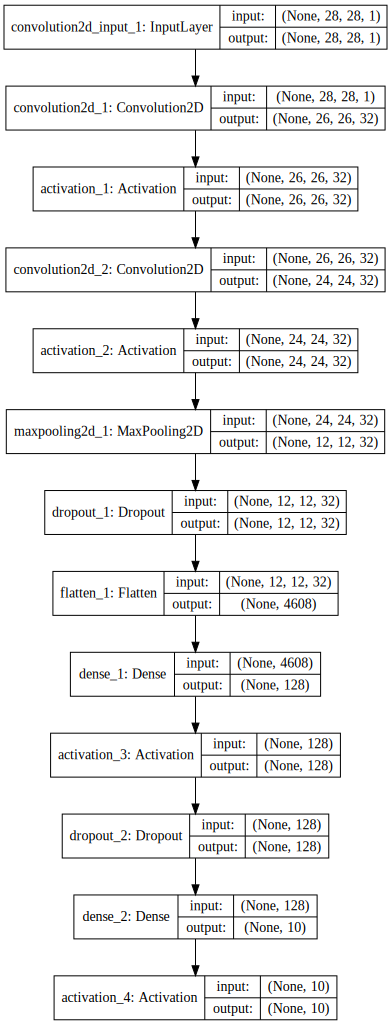

In [36]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

batch_size = 128 # バッチのサイズ
nb_epoch = 12 # エポック数; 繰り返す回数

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 198s - loss: 0.1453 - acc: 0.9576 - val_loss: 0.0624 - val_acc: 0.9802
Epoch 2/12
60000/60000 [==============================] - 226s - loss: 0.1043 - acc: 0.9685 - val_loss: 0.0517 - val_acc: 0.9824
Epoch 3/12
60000/60000 [==============================] - 234s - loss: 0.0860 - acc: 0.9741 - val_loss: 0.0416 - val_acc: 0.9856
Epoch 4/12
60000/60000 [==============================] - 219s - loss: 0.0752 - acc: 0.9777 - val_loss: 0.0369 - val_acc: 0.9870
Epoch 5/12
60000/60000 [==============================] - 250s - loss: 0.0681 - acc: 0.9799 - val_loss: 0.0359 - val_acc: 0.9880
Epoch 6/12
60000/60000 [==============================] - 227s - loss: 0.0611 - acc: 0.9820 - val_loss: 0.0324 - val_acc: 0.9882
Epoch 7/12
60000/60000 [==============================] - 269s - loss: 0.0561 - acc: 0.9831 - val_loss: 0.0315 - val_acc: 0.9897
Epoch 8/12
22272/60000 [==========>............

KeyboardInterrupt: 

最適化関数については、[「勾配降下法の最適化アルゴリズムを概観する」](http://postd.cc/optimizing-gradient-descent/)を参照してください。

In [ ]:
print(model.to_yaml())